### http://data.un.org/Explorer.aspx 

#### Energy Statistics Database


### 1.) For 2018, what was the percentage of the World’s electricity generation by the following sources - Coal, Oil, Natural Gas, Biofuels, Hydro, Nuclear, solar, and wind?


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# change to True to see print statements
verbose = False

### Combine Data Files

#### The UNdata Explorer interface was used to gather the data for this analysis. Due to the how the interface is designed, seperate queries were made to collect all of the relevant data. For ease of use I will combine all of the datasets into a single dataframe.

In [2]:
# read data into a dataframe
df = pd.read_csv('thermal.csv')
filenames = ['hydro.csv', 'nuclear.csv', 'solar.csv', 'wind.csv']
for sector in filenames:
    temp = pd.read_csv(sector)
    df = df.append(temp)

### Organize Data into Energy Sources

#### Disclaimer: I am making the assumptions that it is reasonable to aggregate groups of commodities together to form the groups:

#### Coal: Hard Coal, Solid Coal Products, Brown Coal
#### Oil: Gas Oil / Diesel Oil, Fuel Oil, Other Oil Products, Oil Shale
#### Natural Gas: Natural Gas
#### Biofuels: Solid Biofuels, Liquid Biofueld, Biogases

##### note: if this were a task at work, I would consult with a subject matter expert or spend time researching the topic more in depth before making the decisions on aggregation

In [3]:
# fetch list of commodities
coms = df['Commodity - Transaction'].unique()

# print out commodities and their positions in list
if verbose:
    for idx, com in enumerate(coms):
        print('{} : {}'.format(idx, com))
        
# aggregate groups into energy sources
coal_group = [coms[1], coms[13], coms[14]]
oil_group = [coms[2], coms[3], coms[8], coms[17]]
ng_group = [coms[4]]
biofuel_group = [coms[9], coms[10], coms[12]]
other_thermal = [coms[0]]
hydro_group = [coms[20]]
nuclear_group = [coms[21]]
solar_group = [coms[22]]
wind_group = [coms[23]]

sectors = {'coal': coal_group, 
           'oil': oil_group, 
           'natural_gas': ng_group, 
           'biofuels': biofuel_group, 
           'other_thermal': other_thermal,
           'hydro': hydro_group,
           'nuclear': nuclear_group,
           'solar': solar_group,
           'wind': wind_group
          }

# display groups
if verbose:
    for sector in sectors:
        print('===================================================')
        print('                    {}                    '.format(sector))
        for agg in sectors[sector]:
            print(agg)


### Transform Data

In [4]:
# verify that the data meets some criteria before using it in analysis
def validate_data_task1(df):
    
    # check that the year is correct
    if not (df['Year'].to_numpy() == 2018).all():
        return 'error: not all data from 2018'
    
    # check that the units are the same
    if len(df['Unit'].unique()) > 1:
        return 'error: cannot add dissimilar units'
    
    # check that each quantity is not negative
    if df['Quantity'].min() < 0:
        return 'error: negative quantity in data'
    
    return 'data good'

In [5]:
# find energy generated by each source
generation_df = pd.DataFrame()
for sector in sectors:
    
    # extract data
    sector_data = df[df['Commodity - Transaction'].isin(sectors[sector])]
    
    # validate data
    data_check = validate_data_task1(sector_data)
    if data_check != 'data good':
        raise Exception('data validation for {} failed'.format(sector))
    
    # transform data
    generated = sum(sector_data['Quantity'])
    
    # load into dataframe
    generation_df.insert(0, sector, [generated])


# subtract coal, oil, natural gas, and biofuels from total thermal to find other_thermal
generation_df['other_thermal'] = generation_df['other_thermal'] - (generation_df['coal'] +
                                                                   generation_df['oil'] +
                                                                   generation_df['natural_gas'] +
                                                                   generation_df['biofuels']
                                                                  )

In [6]:
# display resulting dataframe
generation_df

,wind,solar,nuclear,hydro,other_thermal,biofuels,natural_gas,oil,coal
0,1.272283e+06,565067.347833,2708655.22,4.305553e+06,398303.048516,459376.557346,6.164953e+06,682184.356614,9.944870e+06


### Analysis

In [7]:
# extract data from dataframe
sectors = list(generation_df.columns)
kwh_generated = np.array(generation_df.iloc[0])

# sort ascending by kWh, save order
sorted_indices = np.argsort(kwh_generated)
kwh_generated.sort()
sectors = [sectors[i] for i in sorted_indices]

# to answer percentage of energy generation
percent_generation = 100 * kwh_generated / sum(kwh_generated)

Text(0.5, 1.0, '2018 Energy Generation by Source')

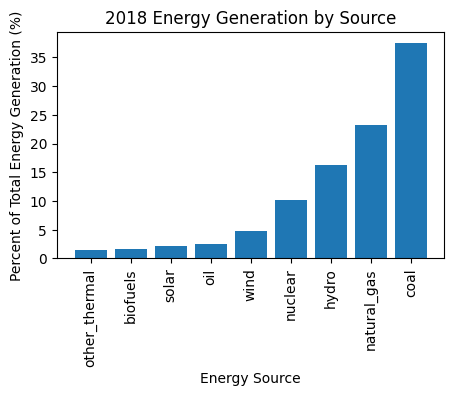

In [8]:
# make plot for percentage usage
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100
plt.bar(np.arange(len(percent_generation)), percent_generation)
plt.xticks(ticks = range(0, len(percent_generation)), labels=sectors, rotation='vertical')
plt.xlabel('Energy Source')
plt.ylabel('Percent of Total Energy Generation (%)')
plt.title('2018 Energy Generation by Source')

Text(0.5, 1.0, '2018 Percent Energy Generation by Source')

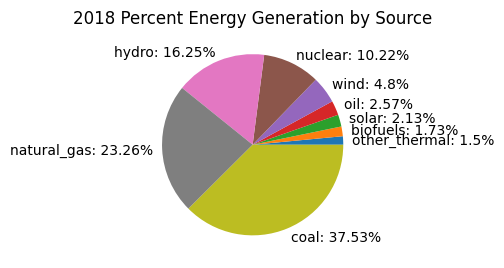

In [9]:
# pie charts are useful for visualizations
name_percents = [name + ': ' + str(round(percent_generation[idx], 2)) + '%' for idx, name in enumerate(sectors)]
plt.pie(percent_generation, labels = name_percents)
plt.title('2018 Percent Energy Generation by Source')


### 2.) For the decade spanning 2008-2018, what was the worldwide energy consumption by the following sectors - households, industry, transport, agriculture, and commercial / public services?


In [10]:
import pandas as pd
import numpy as np

### Read Data

In [11]:
# change to True to see print statements
verbose = False

# read data into a dataframe
filename = 'total_electricity_2008_2018.csv'
df = pd.read_csv(filename)

### Extract Data

In [12]:
# fetch unique list of commodities
total_coms = df['Commodity - Transaction'].unique()

# filter on 'Consumption' to get relevant groups
mask = [True if com.find('Consumption') > 0 else False for com in total_coms]
coms = total_coms[mask]

# view relevent commodities
if verbose:
    for idx, com in enumerate(coms):
        print('{} : {}'.format(idx, com))

# manually pull and group commodities into specified sectors
households_group = [coms[4]]
transport_group = list(coms[18:22]) + list(coms[23:25])
agriculture_group = [coms[5]]
commercial_public_services_group = [coms[7]]
industry_group = list(coms[0:3])

# store groups in a dict
sectors = {'households': households_group, 
           'transport': transport_group, 
           'agriculture': agriculture_group, 
           'commercial_public_services': commercial_public_services_group, 
           'industry': industry_group
          }

# display contents of each sector
if verbose:
    for sector in sectors:
        print('===================================================')
        print('                    {}                    '.format(sector))
        for agg in sectors[sector]:
            print(agg)


# flatten to list of commodities for easy filtering
coms = [item for i in sectors for item in sectors[i]]

# filter out unused entries from dataframe
df = df[df['Commodity - Transaction'].isin(coms)]
df = df[df['Year'].notna()] # (drop nans)

#### Disclaimer: I am making the assumptions that it is reasonable to aggregate groups of commodities together to form the sectors:

#### Households: Households
#### Transport: Transport; Rail; Pipeline Transport; Transport Equipment; Road; Not Elsewhere Specified (transport)
#### Agriculture: Agriculture, Forest, and Fishing
#### Commercial / Public Services: Commercial and Public Services
#### Industry: Manufacturing, Construction, Non-fuel Industry; Other Manufacturing and Non-fuel Industry; Not Elsewhere Specified (industry)

##### note: if this were a task at work, I would consult with a subject matter expert or spend time researching the topic more in depth before making the decisions on aggregation

### Validate Data

In [13]:
# verify that the data meets some criteria before using it in analysis
def validate_data_task2(df):
    
    # check that the year is correct
    if not (df['Year'].to_numpy() > 2007).all() and (df['Year'].to_numpy() < 2019).all():
        return 'error: not all data from between 2008 and 2018 (inclusive)'
    
    # check that the units are the same
    if len(df['Unit'].unique()) > 1:
        return 'error: cannot add dissimilar units'
    
    # check that each quantity is not negative
    if df['Quantity'].min() < 0:
        return 'error: negative quantity in data'
    
    return 'data good'

# validate data
data_check = validate_data_task2(df)
if data_check != 'data good':
    raise Exception('data validation failed')

### Transform Data

In [14]:
# create new dataframe consisting of total energy usage by sector for each year
years = df['Year'].unique()
usage_df = pd.DataFrame(columns = sectors.keys())


# fill dataframe, summing sectors over each year
for year in years:
    for idx, group in enumerate(sectors):
        usage_df.loc[year, group] = round(sum(df[(df['Year'] == year) & 
                                                 (df['Commodity - Transaction'].isin(sectors[group]))]['Quantity']), 2)

In [15]:
usage_df

,households,transport,agriculture,commercial_public_services,industry
2018.0,6001257.41,991511.09,675963.22,4329228.6,20900782.1
2017.0,5780085.27,936882.95,651549.06,4265571.99,19915046.4
2016.0,5700906.86,920655.86,620399.76,4233395.28,18863001.25
2015.0,5495384.13,885349.31,579902.72,4164842.34,18568455.8
2014.0,5378756.17,881701.51,558760.55,4081491.74,18201652.06
2013.0,5304907.67,867638.83,544948.47,4079399.98,17758469.18
2012.0,5112499.01,835113.19,526212.13,4020035.44,17393008.27
2011.0,5004497.96,813308.56,512656.81,3977785.6,16914619.09
2010.0,4986698.5,767120.2,497433.7,3932924.34,15727208.48
2009.0,4693883.53,724711.28,475983.88,3803877.58,14486668.86


In [16]:
# sum over all years to get decade total
decade_summary = usage_df.sum()

# extract data from series
sectors = list(decade_summary.index)
consumption = np.array(decade_summary)

# sort ascending by kWh, save order
sorted_indices = np.argsort(consumption)
consumption.sort()
sectors = [sectors[i] for i in sorted_indices]

### Analysis

Text(0.5, 1.0, '2008-2018 Energy Consumption')

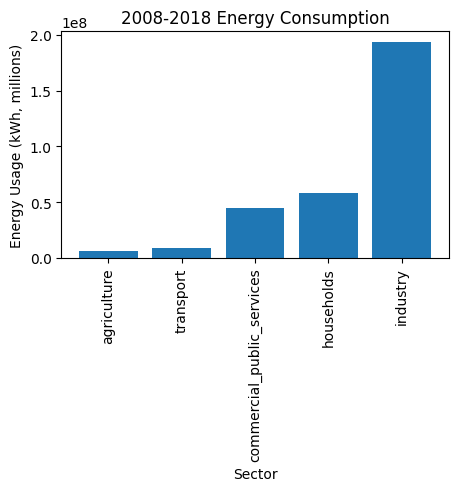

In [17]:
# make plot for percentage usage
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100
plt.bar(np.arange(len(consumption)), consumption)
plt.xticks(ticks = range(0, len(consumption)), labels=sectors, rotation='vertical')
plt.xlabel('Sector')
plt.ylabel('Energy Usage (kWh, millions)')
plt.title('2008-2018 Energy Consumption')

Text(0.5, 1.0, '2008 - 2018 Percent Energy Consumption by Sector')

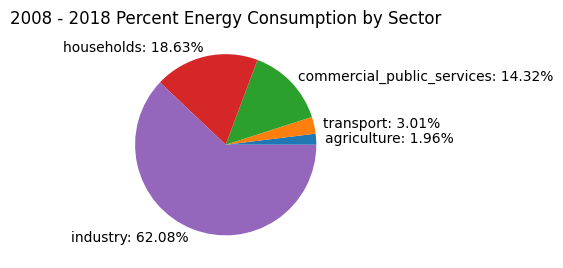

In [18]:
# pie charts are useful for visualizations
percent_consumption = 100 * consumption / sum(consumption)
name_percents = [name + ': ' + str(round(percent_consumption[idx], 2)) + '%' for idx, name in enumerate(sectors)]
plt.pie(consumption, labels = name_percents)
plt.title('2008 - 2018 Percent Energy Consumption by Sector')

### 3.) Lastly, we would like you to list up to two (2) questions you consider would be interesting to ask of the same dataset available.

## Instructions:

### 1.) Please create and share a public git repo on a hosting provider of your choice -Github, Bitbucket, etc.

### 2.) Include a README with steps on how to run your program and generate the answers/visualizations.